In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
tree = Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)

In [4]:
varinfo.clear()

100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


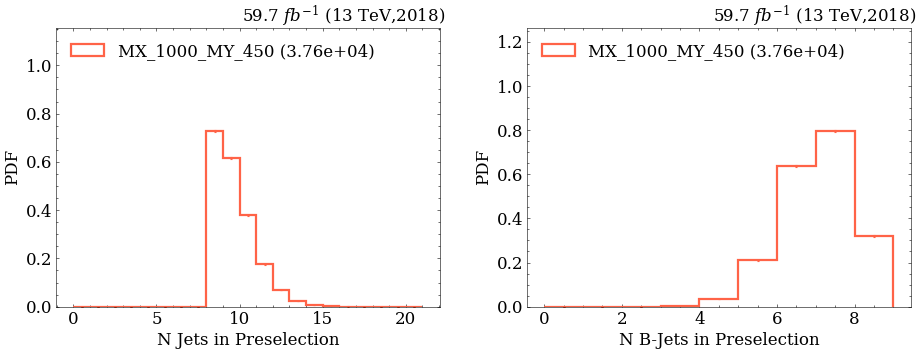

In [5]:
study.quick(
  [tree], density=True, legend=True,
  varlist=['n_jet','nfound_presel'],
  xlabels=['N Jets in Preselection','N B-Jets in Preselection'],
  saveas='n_bjets'
)

In [6]:
all_eightb = EventFilter("eightb", nfound_presel=8)
filter_eightb = CollectionFilter("jet",filter=lambda t:t.jet_signalId>-1)
# eightb = CollectionFilter('jet', filter=lambda t: ( ak.argsort(ak.argsort(-t.jet_btag,axis=-1)) < 8 ) )

tree = all_eightb(tree, filter_eightb)
# tree = eightb(tree)

In [7]:
eightb.build_all_ys(tree)

In [8]:
def event_normalize(array):
  minim, maxim = ak.min(array, axis=-1)[:,None], ak.max(array, axis=-1)[:,None]
  return (array - minim)/(maxim - minim)

In [14]:
jets = get_collection(tree, 'jet', False)
jp4s = [ build_p4(jets[:,i], use_regressed=True) for i in range(8) ]
x_p4 = p4_to_awk(sum_p4(jp4s))

In [34]:
def boost_array(array, boost):
  array_p4 = build_p4(array)
  boost_p4 = build_p4(boost)
  boosted = p4_to_awk(array_p4.boost_p4(-boost_p4))
  return join_fields(array, boosted)


In [35]:
y1 = get_collection(tree, 'y1', False)
y2 = get_collection(tree, 'y2', False)

y1_boosted = boost_array(y1, x_p4)
y2_boosted = boost_array(y2, x_p4)

In [49]:
def calc_diff(y1, y2):
  dm= np.abs(y1.m - y2.m)/(y1.m + y2.m)
  dpt=np.abs(y1.pt - y2.pt)/(y1.pt + y2.pt)
  dphi = calc_dphi(y1.phi, y2.phi)
  deta = np.abs(calc_deta(y1.eta, y2.eta))
  mask = (y1.signalId>0)&(y2.signalId>0)
  return dm, dpt, dphi, deta, mask

# dm, dpt, dphi, deta, mask = calc_diff(y1_boosted, y2_boosted)

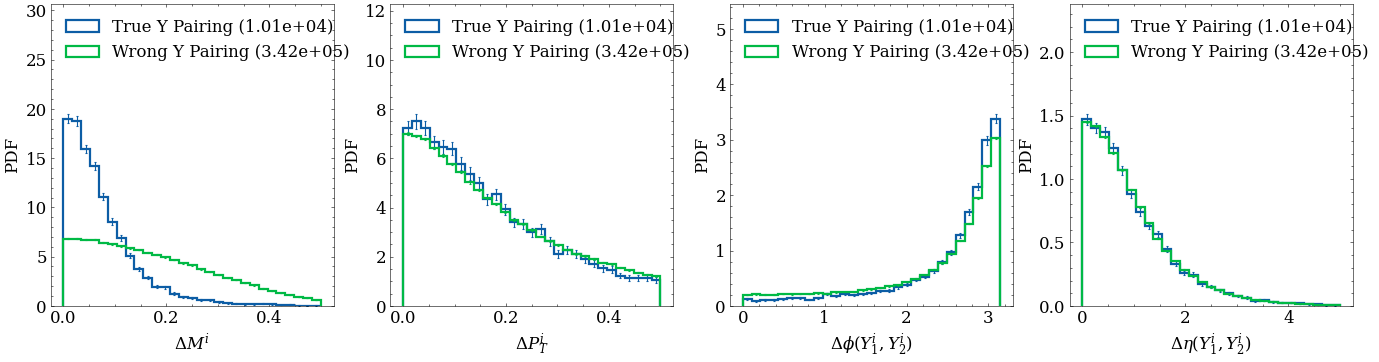

In [58]:
dm, dpt, dphi, deta, mask = calc_diff(y1, y2)

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
fig, axs = study.get_figax(nvar=4, dim=(-1,4))

kwargs = dict(h_label=['True Y Pairing','Wrong Y Pairing'], legend=True, density=True)
hist_multi([dm[mask], dm[~mask]], bins=np.linspace(0,0.5,30), xlabel='$\Delta M^i$', figax=(fig, axs.flat[0]), **kwargs)
hist_multi([dpt[mask], dpt[~mask]], bins=np.linspace(0,0.5,30), xlabel='$\Delta P_{T}^i$', figax=(fig, axs.flat[1]), **kwargs)
hist_multi([dphi[mask], dphi[~mask]], bins=np.linspace(0,np.pi,30), xlabel='$\Delta\phi(Y^i_1,Y^i_2)$', figax=(fig, axs.flat[2]), **kwargs)
hist_multi([deta[mask], deta[~mask]], bins=np.linspace(0,5,30), xlabel='$\Delta\eta(Y^i_1,Y^i_2)$', figax=(fig, axs.flat[3]), **kwargs)

study.save_fig(fig, '', 'y_pairing_vars')

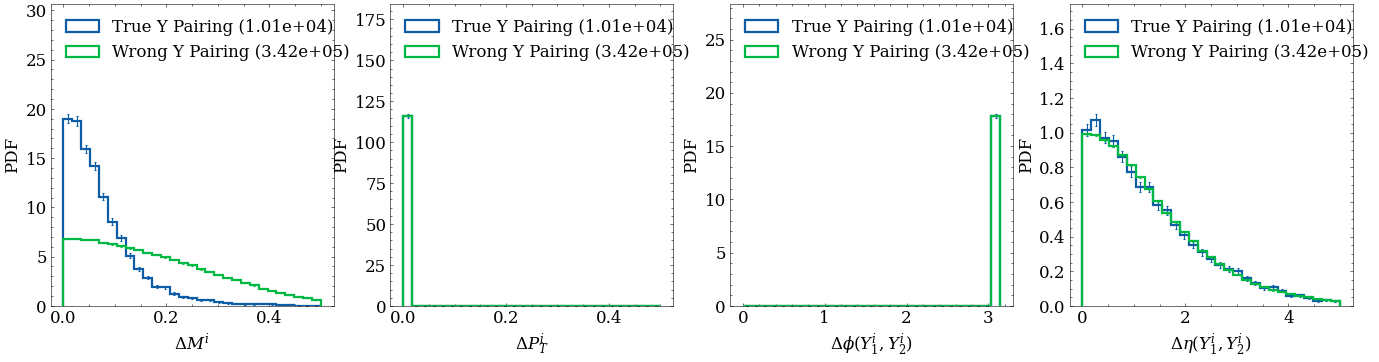

In [59]:
dm, dpt, dphi, deta, mask = calc_diff(y1_boosted, y2_boosted)

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
fig, axs = study.get_figax(nvar=4, dim=(-1,4))

kwargs = dict(h_label=['True Y Pairing','Wrong Y Pairing'], legend=True, density=True)
hist_multi([dm[mask], dm[~mask]], bins=np.linspace(0,0.5,30), xlabel='$\Delta M^i$', figax=(fig, axs.flat[0]), **kwargs)
hist_multi([dpt[mask], dpt[~mask]], bins=np.linspace(0,0.5,30), xlabel='$\Delta P_{T}^i$', figax=(fig, axs.flat[1]), **kwargs)
hist_multi([dphi[mask], dphi[~mask]], bins=np.linspace(0,np.pi,30), xlabel='$\Delta\phi(Y^i_1,Y^i_2)$', figax=(fig, axs.flat[2]), **kwargs)
hist_multi([deta[mask], deta[~mask]], bins=np.linspace(0,5,30), xlabel='$\Delta\eta(Y^i_1,Y^i_2)$', figax=(fig, axs.flat[3]), **kwargs)

study.save_fig(fig, '', 'y_pairing_vars')

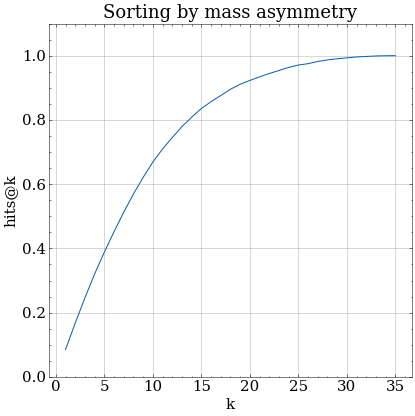

In [14]:
order = ak.argsort(dm, axis=-1)
selection = mask[order]

k = np.arange(35)
eff = np.array([ np.mean(selection[:,i]) for i in k ])
fig, ax = plt.subplots()
ax.plot(k+1, eff.cumsum())
ax.set(ylabel='hits@k',xlabel='k', ylim=(0,1.1), title='Sorting by mass asymmetry')
ax.grid(True)

study.save_fig(fig, '', 'dm_hits')

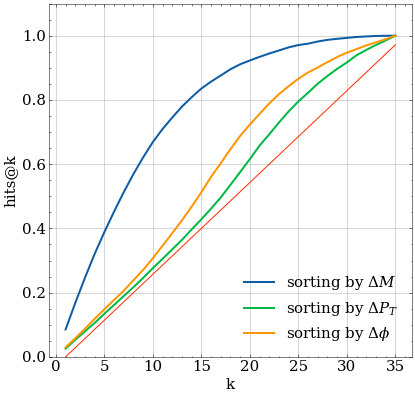

In [57]:


k = np.arange(35)

order = ak.argsort(dm, axis=-1)
selection = mask[order]
dm_eff = np.array([ np.mean(selection[:,i]) for i in k ])

order = ak.argsort(dpt, axis=-1)
selection = mask[order]
dpt_eff = np.array([ np.mean(selection[:,i]) for i in k ])

order = ak.argsort(-dphi, axis=-1)
selection = mask[order]
dphi_eff = np.array([ np.mean(selection[:,i]) for i in k ])

fig, ax = plt.subplots()
ax.plot(k+1, dm_eff.cumsum(), label='sorting by $\Delta M$', linewidth=2)
ax.plot(k+1, dpt_eff.cumsum(), label='sorting by $\Delta P_{T}$', linewidth=2)
ax.plot(k+1, dphi_eff.cumsum(), label='sorting by $\Delta\phi$', linewidth=2)
ax.plot(k+1, ((k)/35))
ax.set(ylabel='hits@k',xlabel='k', ylim=(0,1.1))
ax.legend()
ax.grid(True)

study.save_fig(fig, '', 'dm_vs_dphi')

In [15]:
def _select(score, cutoff, mask, toparg=None):
  if toparg is not None:
    score = score[toparg]
    mask = mask[toparg]
  toparg = ak.argsort(score, axis=-1)[:,:cutoff]
  return toparg, mask

def select(scores, cutoffs, mask, toparg=None):
  for score, cutoff in zip(scores, cutoffs):
    toparg, mask = _select(score, cutoff, mask, toparg)
  return ak.mean( mask[toparg] )

In [157]:
cutoffs = np.arange(1, 35)
dm_dphi_cutoff = np.array([ select([dm, -dphi], [x, 1], mask) for x in cutoffs ])
dphi_dm_cutoff = np.array([ select([-dphi, dm], [x, 1], mask) for x in cutoffs ])

dm -> dphi: (2,1) eff: 0.0900407919609989
dphi -> dm: (22,1) eff: 0.09620933240473585


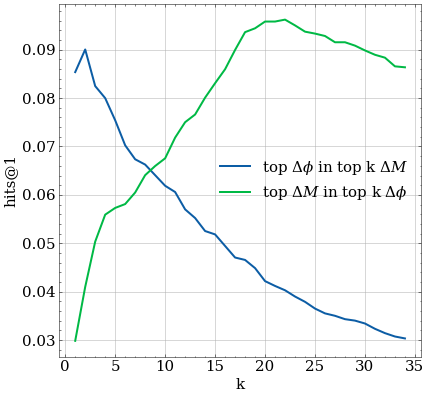

In [158]:
fig, ax = plt.subplots()

ax.plot(cutoffs, dm_dphi_cutoff, label='top $\Delta\phi$ in top k $\Delta M$', linewidth=2)
ax.plot(cutoffs, dphi_dm_cutoff, label='top $\Delta M$ in top k $\Delta\phi$', linewidth=2)
ax.set(xlabel='k', ylabel='hits@1')
ax.grid(True)
ax.legend()

study.save_fig(fig, '', 'compare_2var_hits')

print('dm -> dphi:',f'({cutoffs[ak.argmax(dm_dphi_cutoff)]},1)',f'eff: {ak.max(dm_dphi_cutoff)}')
print('dphi -> dm:',f'({cutoffs[ak.argmax(dphi_dm_cutoff)]},1)',f'eff: {ak.max(dphi_dm_cutoff)}')


In [160]:
select_dm = ak.argsort(dm, axis=-1)[:,:1]
y1_dm = y1[select_dm]
y2_dm = y2[select_dm]

In [161]:
select_dphi_dm = ak.argsort(-dphi, axis=-1)[:,:22]
dphi_dm = dm[select_dphi_dm]
y1_dphi_dm = y1[select_dphi_dm]
y2_dphi_dm = y2[select_dphi_dm]
select_dphi_dm = ak.argsort(dphi_dm, axis=-1)[:,:1]
y1_dphi_dm = y1_dphi_dm[select_dphi_dm]
y2_dphi_dm = y2_dphi_dm[select_dphi_dm]


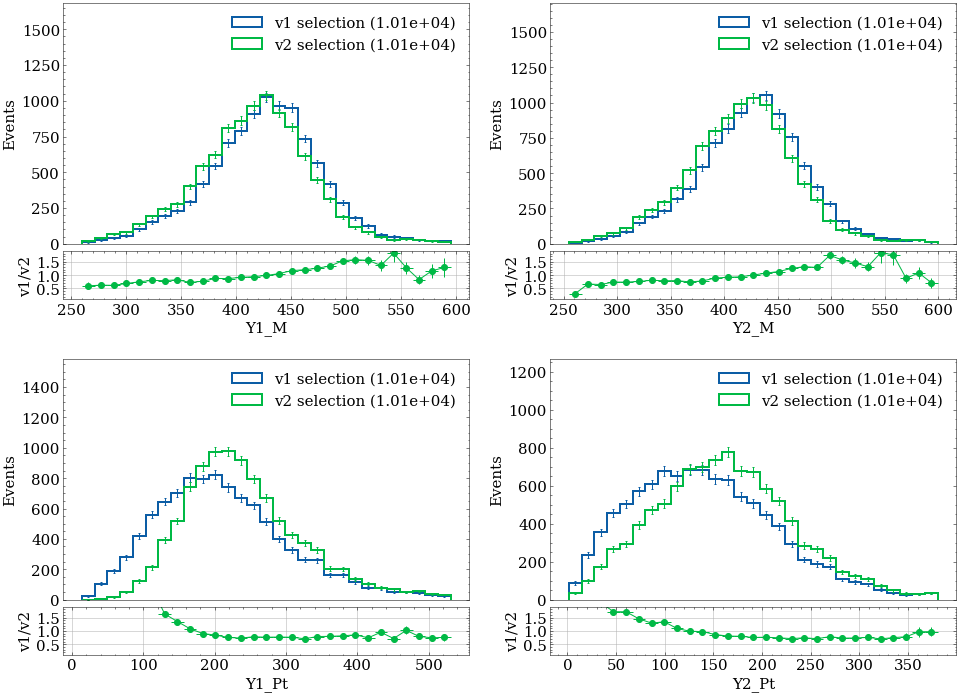

In [162]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,12))

kwargs = dict(h_label=['v1 selection','v2 selection'], legend=True, ratio=True, r_ylabel='v1/v2')
hist_multi([y1_dm.m, y1_dphi_dm.m], figax=(fig, axs.flat[0]), xlabel='Y1_M', **kwargs)
hist_multi([y2_dm.m, y2_dphi_dm.m], figax=(fig, axs.flat[1]), xlabel='Y2_M', **kwargs)
hist_multi([y1_dm.pt, y1_dphi_dm.pt], figax=(fig, axs.flat[2]), xlabel='Y1_Pt', **kwargs)
hist_multi([y2_dm.pt, y2_dphi_dm.pt], figax=(fig, axs.flat[3]), xlabel='Y2_Pt', **kwargs)

study.save_fig(fig, '', 'compare_selection')